Reference: https://pennylane.ai/qml/demos/tutorial_vqe_qng
Quantum Natural Gradient(QNG)의 VQE 적용 사례를 2개 보겠음:
* estimating the ground state energy of a single-qbuit VQE problem
* hydrogen molecule

## Single-qubit VQE

In [1]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

Here, we consider single-qubit Hamiltonian: $\sigma_x + \sigma_z$ 

In [2]:
dev = qml.device("default.qubit", wires=1)

def circuit(params, wires = 0):
    qml.RY(params[0], wires=wires)
    qml.RZ(params[1], wires=wires)

We then define our cost function which supports the computation of block-diagonal or diagonal approximations to the Fubini-Study metric tensor. This tensor is a crucial component for optimizing with quantum natural gradients

In [3]:
coeffs = [1,1]
obs = [qml.X(0), qml.Z(0)]

H = qml.Hamiltonian(coeffs, obs)

@qml.qnode(dev)
def cost_fn(params):
    circuit(params)
    return qml.expval(H)

경사하강이랑 QNG랑 비교할 것

In [4]:
init_params = np.array([3.97507603, 3.00854038], requires_grad=True)

max_iter = 500
conv_tol = 1e-06 # convergence tolerance
step_size = 0.01

In [5]:
# 경사하강
opt = qml.GradientDescentOptimizer(stepsize=step_size)
params = init_params
gd_param_history = [params]
gd_cost_history = []
for n in range(max_iter):

    params, prev_energy = opt.step_and_cost(cost_fn, params)
    gd_param_history.append(params)
    gd_cost_history.append(cost_fn(params))

    energy = cost_fn(params)

    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 0.04154644 Ha,  Convergence parameter = 0.01988725 Ha
Iteration = 20,  Energy = -0.34887192 Ha,  Convergence parameter = 0.01871332 Ha
Iteration = 40,  Energy = -0.68855798 Ha,  Convergence parameter = 0.01516827 Ha
Iteration = 60,  Energy = -0.94698685 Ha,  Convergence parameter = 0.01090052 Ha
Iteration = 80,  Energy = -1.12456294 Ha,  Convergence parameter = 0.00719639 Ha
Iteration = 100,  Energy = -1.23851190 Ha,  Convergence parameter = 0.00450353 Ha
Iteration = 120,  Energy = -1.30866473 Ha,  Convergence parameter = 0.00273374 Ha
Iteration = 140,  Energy = -1.35089482 Ha,  Convergence parameter = 0.00163444 Ha
Iteration = 160,  Energy = -1.37606106 Ha,  Convergence parameter = 0.00097192 Ha
Iteration = 180,  Energy = -1.39102656 Ha,  Convergence parameter = 0.00057850 Ha
Iteration = 200,  Energy = -1.39995438 Ha,  Convergence parameter = 0.00034617 Ha
Iteration = 220,  Energy = -1.40531777 Ha,  Convergence parameter = 0.00020895 Ha
Iteration = 240,  Energ

In [6]:
opt = qml.QNGOptimizer(stepsize=step_size, approx="block-diag")

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

for n in range(max_iter):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params) 
    # 여기서 params은 갱신 후이며, prev_energy는 갱신 전 에너지 값이다.

    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = -0.01845160 Ha,  Convergence parameter = 0.07988529 Ha
Iteration = 20,  Energy = -1.13290016 Ha,  Convergence parameter = 0.03070807 Ha
Iteration = 40,  Energy = -1.38395171 Ha,  Convergence parameter = 0.00369027 Ha
Iteration = 60,  Energy = -1.41123656 Ha,  Convergence parameter = 0.00036725 Ha
Iteration = 80,  Energy = -1.41392341 Ha,  Convergence parameter = 0.00003583 Ha
Iteration = 100,  Energy = -1.41418531 Ha,  Convergence parameter = 0.00000349 Ha

Final value of the energy = -1.41420572 Ha
Number of iterations =  111


### Visualizing the results

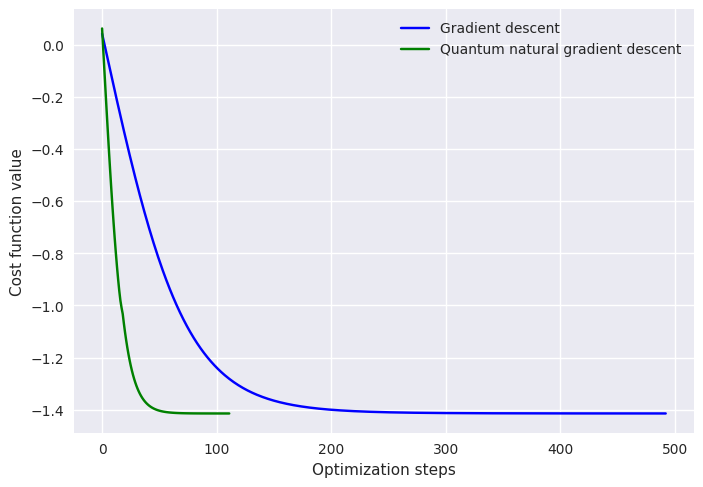

In [7]:
plt.style.use("seaborn-v0_8")
plt.plot(gd_cost_history, "b", label="Gradient descent")
plt.plot(qngd_cost_history, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

## Hydrogen VQE Example  

In [2]:
dataset = qml.data.load('qchem',molname="H2", bondlength=0.7)[0]
# bondlength: 분자 내 원자 간 거리(옴스트롱 단위)
hamiltonian, qubits = dataset.hamiltonian, len(dataset.hamiltonian.wires)
# hamiltonian: 분자의 해밀토니안 
hamiltonian_coeffs, hamiltonian_ops = hamiltonian.terms()

print("Number of qubits = ", qubits)

Number of qubits =  4


Ansatz를 조금만 확장하자

In [16]:
dev = qml.device("default.qubit", wires=qubits)
hf_state = np.array([1, 1, 0, 0], requires_grad=False)

def ansatz(params, wires=[0, 1, 2, 3]):
    qml.BasisState(hf_state, wires=wires)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        qml.RZ(params[3 * i + 2], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

여기서 양자 상태를 Hartree-Fock state(hf_state)로 초기화 되어 있음을 인지해야 함.  
Why?  
수소 분자($H_2$)는 전자가 2개인 시스템입니다.
* 만약 $|0000\rangle$ (진공 상태)에서 시작한다면, 회로가 전자를 생성하는 역할까지 수행해야 하며 이 과정에서 전자가 1개나 3개가 되는 비물리적인 상태로 빠질 위험이 있습니다.
* 반면, HF 상태($|1100\rangle$)는 이미 전자 2개가 채워진 상태입니다. 이후 사용하는 양자 회로(Excitation gates)들을 전자의 총 개수를 보존하도록 설계하면, 최적화 과정 내내 "전자 2개"라는 물리적 제약 조건을 자연스럽게 만족시킬 수 있습니다.  

요약하자면  
VQE에서 Hartree-Fock 상태를 쓰는 이유는 **물리적으로 타당한 최소한의 에너지를 가진 상태에서 시작하여, 양자 컴퓨터가 계산하기 힘든 나머지 1%(Correlation energy)만 효율적으로 찾아내기 위해서**라고 할 수 있습니다.릴 수 있습니다.

In [17]:
@qml.qnode(dev, interface="autograd")
def cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

exact_value = dataset.fci_energy # -1.1361895496530567

set up our optimization runs

In [18]:
np.random.seed(0)
init_params = np.random.uniform(low=0, high=2 * np.pi, size=12, requires_grad=True)
max_iterations = 500
step_size = 0.5
conv_tol = 1e-06

표준 경사 하강법

In [19]:
opt = qml.GradientDescentOptimizer(step_size)
params = init_params
gd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    gd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break


print()
print("Final convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.09424484 Ha
Iteration = 20,  Energy = -0.55156649 Ha
Iteration = 40,  Energy = -1.12731550 Ha
Iteration = 60,  Energy = -1.13583273 Ha
Iteration = 80,  Energy = -1.13602376 Ha
Iteration = 100,  Energy = -1.13611105 Ha
Iteration = 120,  Energy = -1.13615247 Ha

Final convergence parameter = 0.00000097 Ha
Number of iterations =  130
Final value of the ground-state energy = -1.13616408 Ha
Accuracy with respect to the FCI energy: 0.00002547 Ha (0.01598211 kcal/mol)

Final circuit parameters = 
 [3.44829694e+00 6.28318531e+00 3.78727399e+00 3.42360201e+00
 5.09255717e-08 4.05827240e+00 2.74944154e+00 6.07360246e+00
 6.24620668e+00 2.40923412e+00 6.28318531e+00 3.32314479e+00]


QNGOptimizer 사용

In [20]:
hamiltonian = qml.Hamiltonian(np.array(hamiltonian_coeffs, requires_grad=False), hamiltonian_ops)

opt = qml.QNGOptimizer(step_size, lam=0.001, approx="block-diag")
# lam: 정규화를 위한 파라미터, psuedo-inverse 계산 시 값이 작으면 수치적 불안정성이 발생할 수 있어 이를 방지하기 위해 사용됨.

params = init_params
qngd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)

    qngd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 4 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Iteration = 0,  Energy = -0.32164654 Ha
Iteration = 4,  Energy = -0.46875045 Ha
Iteration = 8,  Energy = -0.85090214 Ha
Iteration = 12,  Energy = -1.13575345 Ha
Iteration = 16,  Energy = -1.13618926 Ha

Final convergence parameter = 0.00000022 Ha
Number of iterations =  17
Final value of the ground-state energy = -1.13618947 Ha
Accuracy with respect to the FCI energy: 0.00000008 Ha (0.00004853 kcal/mol)

Final circuit parameters = 
 [3.44829694e+00 6.28318510e+00 3.78727399e+00 3.42360201e+00
 4.03274702e-04 4.05827240e+00 2.74944154e+00 6.07375127e+00
 6.28401998e+00 2.40923412e+00 6.28318525e+00 3.32314479e+00]


### Visualizing the results

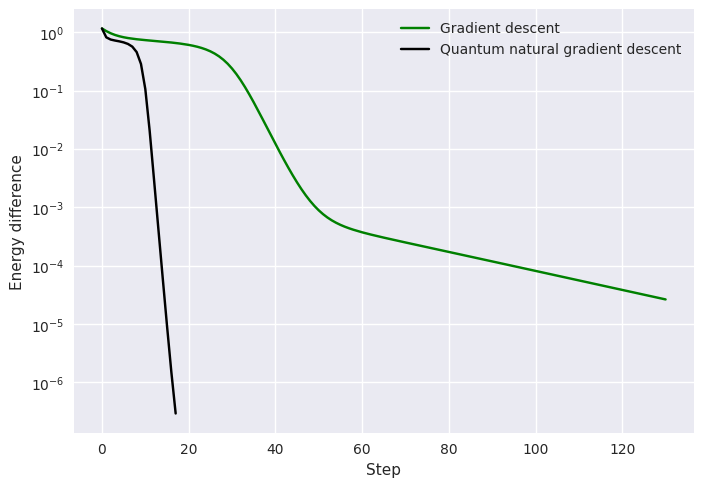

In [21]:
plt.style.use("seaborn-v0_8")
plt.plot(np.array(gd_cost) - exact_value, "g", label="Gradient descent")
plt.plot(np.array(qngd_cost) - exact_value, "k", label="Quantum natural gradient descent")
plt.yscale("log")
plt.ylabel("Energy difference")
plt.xlabel("Step")
plt.legend()
plt.show()

만약 단지 운이 좋은 것이었다면? 시작 파라미터가 좋앗다면?  

이를 확인해보기 위해 trial random parameter를 10회 돌려보고, 평균 및 표준편차로 시각화해보면 다음과 같음
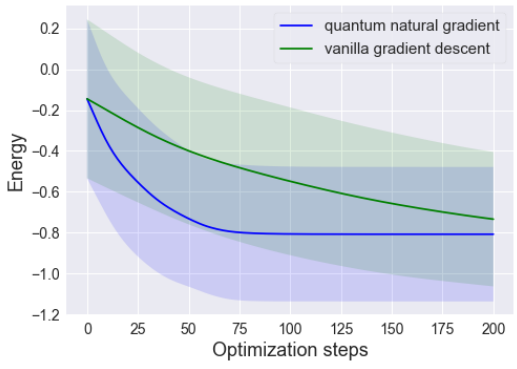
그냥 QNG가 좋네!